# Hybrid Recommender System

**İş Problemi**

ID'si verilen kullanıcı için item-based ve user-based recommender yöntemlerini kullanarak 10 film önerisi yapınız.

**Veri Seti Hikayesi**

Veri seti, bir film tavsiye hizmeti olan MovieLens tarafından sağlanmıştır. İçerisinde filmler ile birlikte bu filmlere yapılan derecelendirme puanlarını barındırmaktadır. 27.278 filmde 2.000.0263 derecelendirme içermektedir. 

Bu veri seti ise 17 Ekim 2016 tarihinde oluşturulmuştur. 138.493 kullanıcı ve 09 Ocak 1995 ile 31 Mart 2015 tarihleri arasında verileri içermektedir. Kullanıcılar rastgele seçilmiştir. Seçilen tüm kullanıcıların en az 20 filme oy verdiği bilgisi mevcuttur.

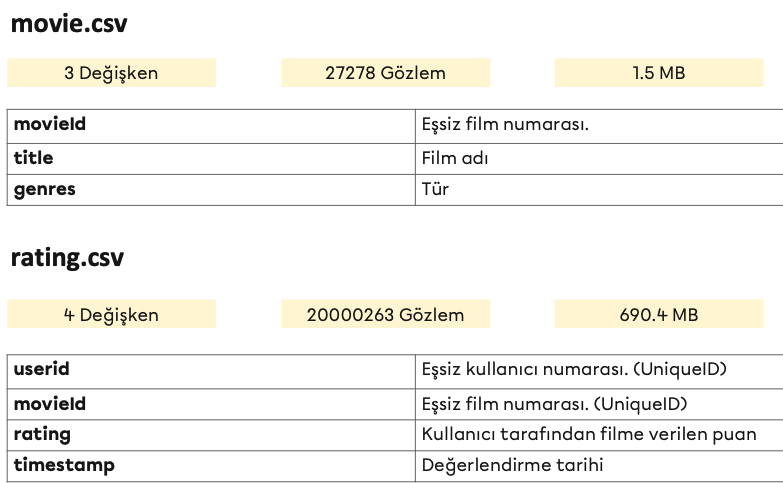

# User Based Recommendation

# Görev 1: Verinin Hazırlanması

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Adım 1: Movie ve Rating veri setlerini okutunuz.
# movieId, film adı ve filmin tür bilgilerini içeren veri seti
movie = pd.read_csv('/kaggle/input/movie-and-rating/movie.csv')

# UserID, film adı, filme verilen oy ve zaman bilgisini içeren veri seti
rating = pd.read_csv('/kaggle/input/movie-and-rating/rating.csv')

In [3]:
# Adım 2: Rating veri setine filmlerin isimlerini ve türünü movie film setini kullanarak ekleyiniz.
# Rating'deki kullanıcıların oy kullandıkları filmlerin sadece id'si var.
# Id'lere ait film isimlerini ve türünü movie veri setinden ekliyoruz.
df = movie.merge(rating, how="left", on="movieId")

In [4]:
df.head(5)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


In [5]:
# Adım 3: Her bir film için toplam kaç kişinin oy kullandığını hesaplayınız. Toplam oy kullanılma sayısı 1000'un altında olan filmleri veri setinden çıkarınız.
# Her bir film için toplam kaç kişinin oy kullanıldığını hesaplıyoruz.
comment_counts = pd.DataFrame(df["title"].value_counts())

# Toplam oy kullanılma sayısı 1000'in altında olan filmlerin isimlerini rare_movies de tutuyoruz ve veri setinden çıkartıyoruz.
rare_movies = comment_counts[comment_counts["count"] <= 1000].index
common_movies = df[~df["title"].isin(rare_movies)]

In [6]:
# Adım 4: index'te userID'lerin, sütunlarda film isimlerinin ve değer olarak da rating'lerin bulunduğu dataframe için pivot table oluşturunuz.
user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")

In [7]:
# Adım 5: Yukarıda yapılan tüm işlemleri fonksiyonlaştıralım
def create_user_movie_df():
    import pandas as pd
    movie = pd.read_csv('/kaggle/input/movie-and-rating/movie.csv')
    rating = pd.read_csv('/kaggle/input/movie-and-rating/rating.csv')
    df = movie.merge(rating, how="left", on="movieId")
    comment_counts = pd.DataFrame(df["title"].value_counts())
    rare_movies = comment_counts[comment_counts["count"] <= 1000].index
    common_movies = df[~df["title"].isin(rare_movies)]
    user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")
    return user_movie_df


user_movie_df = create_user_movie_df()

# Görev 2: Öneri Yapılacak Kullanıcının İzlediği Filmlerin Belirlenmesi

In [8]:
# Adım 1: Rastgele bir kullanıcı id'si seçiniz.
random_user = int(pd.Series(user_movie_df.index).sample(1, random_state=45).values)

/tmp/ipykernel_18/61434289.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_user = int(pd.Series(user_movie_df.index).sample(1, random_state=45).values)


In [9]:
# Adım 2: Seçilen kullanıcıya ait gözlem birimlerinden oluşan random_user_df adında yeni bir dataframe oluşturunuz.
random_user_df = user_movie_df[user_movie_df.index == random_user]

In [10]:
# Adım 3: Seçilen kullanıcının oy kullandığı filmleri movies_watched adında bir listeye atayınız.
movies_watched = random_user_df.columns[random_user_df.notna().any()].tolist()

# Görev 3: Aynı Filmleri İzleyen Diğer Kullanıcıların Verisine ve Id'lerine Erişmek

In [11]:
# Adım 1: Seçilen kullanıcının izlediği fimlere ait sutunları user_movie_df'ten seçiniz ve movies_watched_df adında yeni bir dataframe oluşturuyoruz.
movies_watched_df = user_movie_df[movies_watched]

In [12]:
# Adım 2: Her bir kullancının seçili user'ın izlediği filmlerin kaçını izlediği bilgisini taşıyan user_movie_count adında yeni bir dataframe oluşturunuz.
user_movie_count = movies_watched_df.T.notnull().sum()
user_movie_count = user_movie_count.reset_index()
user_movie_count.columns = ["userId", "movie_count"]

In [13]:
# Adım 3: Seçilen kullanıcının oy verdiği filmlerin yüzde 60 ve üstünü izleyenleri benzer kullanıcılar olarak görüyoruz.
# Bu kullanıcıların id’lerinden users_same_movies adında bir liste oluşturunuz.

perc = len(movies_watched) * 60 / 100
users_same_movies = user_movie_count[user_movie_count["movie_count"] > perc]["userId"]

# Görev 4: Öneri Yapılacak Kullanıcı ile En Benzer Kullanıcıların Belirlenmesi

In [14]:
# Adım 1: user_same_movies listesi içerisindeki seçili user ile benzerlik gösteren kullanıcıların id’lerinin bulunacağı şekilde movies_watched_df dataframe’ini filtreleyiniz.
final_df = pd.concat([movies_watched_df[movies_watched_df.index.isin(users_same_movies)],
                      random_user_df[movies_watched]])

In [15]:
# Adım 2: Kullanıcıların birbirleri ile olan korelasyonlarının bulunacağı yeni bir corr_df dataframe’i oluşturunuz.
corr_df = final_df.T.corr().stack().sort_values().drop_duplicates()

corr_df = pd.DataFrame(corr_df, columns=["corr"])

corr_df.index.names = ['user_id_1', 'user_id_2']

corr_df = corr_df.reset_index()

In [16]:
# Adım 3: Seçili kullanıcı ile yüksek korelasyona sahip (0.65’in üzerinde olan) kullanıcıları filtreleyerek top_users adında yeni bir dataframe oluşturunuz.
top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] >= 0.65)][
    ["user_id_2", "corr"]].reset_index(drop=True)

top_users = top_users.sort_values(by='corr', ascending=False)

top_users.rename(columns={"user_id_2": "userId"}, inplace=True)

In [17]:
# Adım 4:  top_users dataframe’ine rating veri seti ile merge ediniz
rating = pd.read_csv('/kaggle/input/movie-and-rating/rating.csv')

top_users_ratings = top_users.merge(rating[["userId", "movieId", "rating"]], how='inner')

top_users_ratings = top_users_ratings[top_users_ratings["userId"] != random_user]

# Görev 5: Weighted Average Recommendation Score'un Hesaplanması ve İlk 5 Filmin Tutulması

In [18]:
# Adım 1: Her bir kullanıcının corr ve rating değerlerinin çarpımından oluşan weighted_rating adında yeni bir değişken oluşturunuz.
top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']

In [19]:
# Adım 2: Film id’si ve her bir filme ait tüm kullanıcıların weighted rating’lerinin ortalama değerini içeren recommendation_df adında yeni bir dataframe oluşturunuz.
top_users_ratings.groupby('movieId').agg({"weighted_rating": "mean"})

recommendation_df = top_users_ratings.groupby('movieId').agg({"weighted_rating": "mean"})
recommendation_df = recommendation_df.reset_index()

In [20]:
# Adım 3: recommendation_df içerisinde weighted rating'i 3.5'ten büyük olan filmleri seçiniz ve weighted rating’e göre sıralayınız.
# İlk 5 gözlemi movies_to_be_recommend olarak kaydediniz.
recommendation_df[recommendation_df["weighted_rating"] > 3.5]

movies_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 3.5].sort_values("weighted_rating", ascending=False)

# Film isimleri ile birleştiriyoruz.
movie = pd.read_csv('/kaggle/input/movie-and-rating/movie.csv')
movies_to_be_recommend = movies_to_be_recommend.merge(movie[["movieId", "title"]])

In [21]:
# Adım 4:  Tavsiye edilen 5 filmin isimlerini getiriniz.
movies_to_be_recommend["title"][0:5]

0                      Whatever (1998)
1       Incredible Journey, The (1963)
2    Journey of Natty Gann, The (1985)
3                She's All That (1999)
4                     Metroland (1997)
Name: title, dtype: object

# Item Based Recommendation

**Kullanıcının en son izlediği ve en yüksek puan verdiği filmin adına göre item-based öneri yapınız.**

In [22]:
# Adım 1: movie,rating veri setlerini okutunuz.
import pandas as pd
pd.set_option('display.max_columns', 500)
user_id = 108170
movie = pd.read_csv('/kaggle/input/movie-and-rating/movie.csv')
rating = pd.read_csv('/kaggle/input/movie-and-rating/rating.csv')

In [23]:
# Adım 2: Öneri yapılacak kullanıcının 5 puan verdiği filmlerden puanı en güncel olan filmin id'sinin alınız.
movie_id = rating[(rating["userId"] == user_id) & (rating["rating"] == 5.0)].sort_values(by="timestamp", ascending=False)["movieId"][0:1].values[0]

In [24]:
# Adım 3: User based recommendation bölümünde oluşturulan user_movie_df dataframe’ini seçilen film id’sine göre filtreleyiniz.
movie[movie["movieId"] == movie_id]["title"].values[0]
movie_df = user_movie_df[movie[movie["movieId"] == movie_id]["title"].values[0]]
movie_df

userId
1.0        NaN
2.0        NaN
3.0        NaN
4.0        NaN
5.0        NaN
            ..
138489.0   NaN
138490.0   NaN
138491.0   NaN
138492.0   NaN
138493.0   NaN
Name: Wild at Heart (1990), Length: 138493, dtype: float64

In [25]:
# Adım 4: Filtrelenen dataframe’i kullanarak seçili filmle diğer filmlerin korelasyonunu bulunuz ve sıralayınız.
user_movie_df.corrwith(movie_df).sort_values(ascending=False).head(10)

title
Wild at Heart (1990)                     1.000000
My Science Project (1985)                0.570187
Mediterraneo (1991)                      0.538868
Old Man and the Sea, The (1958)          0.536192
National Lampoon's Senior Trip (1995)    0.533029
Clockwatchers (1997)                     0.483337
Repo Man (1984)                          0.478674
Lost Highway (1997)                      0.476251
Blue Velvet (1986)                       0.471225
Jeffrey (1995)                           0.457849
dtype: float64

In [26]:
# Adım 5: Seçili film’in kendisi haricinde ilk 5 film’i öneri olarak veriniz.
